<a href="https://colab.research.google.com/github/m-d-nabeel/mnist-dataset/blob/main/next_word_predictor_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

file_path = "next-word-dataset.txt"
dataset_path = "ronikdedhia/next-word-prediction"

if not os.path.exists(file_path):
  print(f"File '{file_path}' not found. Downloading and extracting...")
  os.system(f"kaggle datasets download -d {dataset_path}")
  os.system("unzip -q next-word-prediction.zip")
  os.system("mv 1661-0.txt next-word-dataset.txt")
  os.system("rm -rf 166* *.zip")
else:
  print(f"File '{file_path}' already exists. Skipping download and extraction.")

File 'next-word-dataset.txt' not found. Downloading and extracting...


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
import re

text_dataset = ""

with open("/content/next-word-dataset.txt", "r") as f:
  text_dataset = f.read()

text_dataset = re.sub(r'[^a-zA-Z\s\.\?\!]', '', text_dataset)
text_dataset = text_dataset[1200:]

roman_numeral_pattern = r'\b(?:I{1,3}|IV|V|VI{1,3}|IX|X{1,3}|XL|L|LX{1,3}|XC|C{1,3}|CD|D|DC{1,3}|CM|M{1,3})\b'
text_dataset = re.sub(roman_numeral_pattern, '', text_dataset)
text_dataset = text_dataset.lower()

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts([text_dataset])

In [ ]:
unique_word_count = len(tokenizer.word_counts)
print(unique_word_count)

8578


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sentences = nltk.sent_tokenize(text_dataset)
sentences = [sentence.replace('\n', ' ') if len(sentence.split()) > 2 else None for sentence in sentences]
sentences = [sentence.replace(".", "").strip() for sentence in sentences if sentence is not None]

In [ ]:
print(len(sentences))
print(sentences[:5])

6301
['a scandal in bohemia', 'to sherlock holmes she is always the woman', 'have seldom heard him mention her under any other name', 'in his eyes she eclipses and predominates the whole of her sex', 'it was not that he felt any emotion akin to love for irene adler']


In [ ]:
seqs_sentences = tokenizer.texts_to_sequences(sentences)

In [ ]:
seqs_sentences[4]

[8, 11, 22, 7, 10, 343, 85, 1815, 2504, 4, 614, 21, 674, 675]

In [ ]:
tokenizer.texts_to_sequences(['It was not that he felt any emotion akin to love for Irene Adler.'])[0]

[8, 11, 22, 7, 10, 343, 85, 1815, 2504, 4, 614, 21, 674, 675]

In [ ]:
# # Sample data

# count = 0
# for sequence in seqs_sentences:
#   print(sequence)
#   count += 1
#   if count == 5:
#     break

In [ ]:
training_sequences = []

for seq_sentence in seqs_sentences:
  for i in range(1, len(seq_sentence)):
    training_sequences.append(seq_sentence[:i + 1])

In [ ]:
for i in range(5):
  print(training_sequences[i])

[5, 879]
[5, 879, 6]
[5, 879, 6, 950]
[4, 126]
[4, 126, 32]


In [ ]:
max_word_len = max([len(x) for x in training_sequences])
print(max_word_len)

102


In [ ]:
padded_training_sequences = pad_sequences(sequences=training_sequences, maxlen=max_word_len, padding="pre")

In [ ]:
X = padded_training_sequences[:, :-1]
y = padded_training_sequences[:, -1]

In [ ]:
X

array([[   0,    0,    0, ...,    0,    0,    5],
       [   0,    0,    0, ...,    0,    5,  879],
       [   0,    0,    0, ...,    5,  879,    6],
       ...,
       [   0,    0,    0, ..., 8578,    4,  336],
       [   0,    0,    0, ...,    4,  336,   78],
       [   0,    0,    0, ...,  336,   78,  333]], dtype=int32)

In [ ]:
y

array([ 879,    6,  950, ...,   78,  333, 1569], dtype=int32)

In [ ]:
from keras.utils import to_categorical

y = to_categorical(y, num_classes = unique_word_count + 1)

In [ ]:
print(X.shape)
print(y.shape)

(97009, 101)
(97009, 8579)


## Model Building

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

In [ ]:
# model = Sequential()
# optimizer = Adam()

# # unique_word_count represents the number of unique words in the vocabulary
# # The Embedding layer converts each word (integer) into a dense vector of fixed size.
# # input_dim: size of the vocabulary (+1 is often added to handle out-of-vocabulary or padding cases)
# # output_dim: size of the dense embedding vector for each word
# # input_length: length of the input sequences (in words); max_word_len - 1 as the model predicts the next word

# model.add(
#     Embedding(
#         input_dim = unique_word_count + 1,  # size of vocabulary (+1 for potential padding or OOV token)
#         output_dim = 100,                   # dimension of the embedding vectors (each word is mapped to a 100-dimensional vector)
#         input_length = max_word_len - 1     # length of input sequences; max_word_len - 1 because the model predicts the next word
#     )
# )

# # The LSTM layer processes the sequence of embeddings and outputs a hidden state representation.
# # The LSTM has 150 units, which determines the size of its internal states (ht, ct).
# # Each unit represents a dimension in the LSTM's output and internal states.
# model.add(LSTM(units=128))
# model.add(LSTM(units=64))

# # The Dense layer with 'unique_word_count + 1' units is used to produce a probability distribution over the vocabulary for the next word.
# # The 'softmax' activation function normalizes these outputs to represent probabilities.
# model.add(Dense(units=unique_word_count + 1, activation="softmax"))

# # Compiling the model with the Adam optimizer and categorical crossentropy loss.
# # Categorical crossentropy is appropriate for multi-class classification problems.
# # The model is evaluated on accuracy, which measures the fraction of correct predictions.
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
model = Sequential([
    Embedding(input_dim=unique_word_count + 1, output_dim=100, input_length=max_word_len - 1),
    LSTM(units=128, return_sequences=True),
    LSTM(units=64),
    Dense(units=unique_word_count + 1, activation="softmax")
])

optimizer = Adam()
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 101, 100)          857900    
                                                                 
 lstm (LSTM)                 (None, 101, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 8579)              557635    
                                                                 
Total params: 1582191 (6.04 MB)
Trainable params: 1582191 (6.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


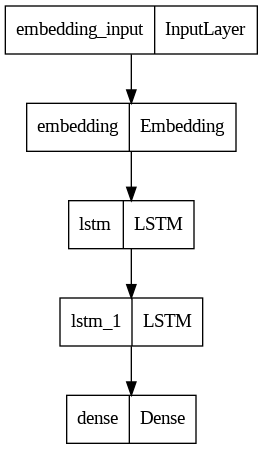

In [ ]:
from keras.utils import plot_model

plot_model(model)

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_weights_only=True,  # Save only the model weights
    save_best_only=True,     # Save only the best model (in terms of monitored quantity)
    mode='max',              # Maximizing validation accuracy
    verbose=1                # Verbosity level (1: progress bar)
)

history = model.fit(
    X, y, epochs=50,
    validation_split=0.02,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
 178/2971 [>.............................] - ETA: 12:13 - loss: 7.3585 - accuracy: 0.0506

In [ ]:
import numpy as np

def predict(text):
    # Tokenize the text
    tokenized_text = tokenizer.texts_to_sequences([text])

    # Since texts_to_sequences returns a list of lists, get the inner list
    tokenized_text = tokenized_text[0]

    # Pad the tokenized text to the specified max length
    padded_token_text = pad_sequences([tokenized_text], maxlen=max_word_len - 1, padding="pre")

    # Ensure the padded_token_text is of shape (1, max_word_len) which the model expects
    # Model expects a 2D array, not a 3D array, so ensure we have the correct dimensions
    padded_token_text = np.array(padded_token_text)  # Convert to a NumPy array if not already

    # Predict the next word's index
    prediction = model.predict(padded_token_text)
    idx = np.argmax(prediction)
    for word, index in tokenizer.word_index.items():
        if index == idx:
            return word
    return "<NIL>"

In [ ]:
predict("Sherlock")

In [ ]:
model.save("next_word_predictor.h5")
model.save("next_word_predictor.keras")

In [ ]:
def predict_N_words(text, num):
  for i in range(num):
    text = f"{text} {predict(text)}"
  return text

In [ ]:
print(predict_N_words("what are", 5))

In [ ]:
print(predict_N_words("I am very sorry", 10))

In [ ]:
print(predict_N_words("I hope", 10))

In [ ]:
import io
import json

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# with open('tokenizer.json') as f:
#     data = json.load(f)
#     tokenizer = tokenizer_from_json(data)

In [ ]:
!python --version

In [ ]:
!pip show tensorflow